In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn import set_config
set_config(display="diagram")
pd.set_option('display.max_columns', None)

In [2]:
#reading data
df=pd.read_csv('accident_data.csv')

In [3]:
#checking missing values percentage
df.isnull().mean()*100

Accident_Index                                  0.000000
1st_Road_Class                                 29.143266
1st_Road_Number                                 0.000191
2nd_Road_Class                                 41.944925
2nd_Road_Number                                 1.030255
Accident_Severity                               0.000000
Carriageway_Hazards                             0.002766
Date                                            0.000000
Day_of_Week                                     0.000000
Did_Police_Officer_Attend_Scene_of_Accident     0.025654
Junction_Control                                0.000000
Junction_Detail                                 0.000000
Latitude                                        0.010586
Light_Conditions                                0.198746
Local_Authority_(District)                      0.000000
Local_Authority_(Highway)                       0.000000
Location_Easting_OSGR                           0.010586
Location_Northing_OSGR         

In [4]:
#identifying columns that contain upto 5 percent missing data
cols_upto_5=[var for var in df.columns if df[var].isnull().mean() < 0.05 and 
            df[var].isnull().mean() > 0]

In [5]:
new_df=df[cols_upto_5].dropna()

In [6]:
df2=df.merge(new_df)

In [7]:
#replacing with Data Missing
df2['2nd_Road_Class'] = df2['2nd_Road_Class'].str.replace('Unclassified','Data Missing')
df2['Junction_Control'] = df2['Junction_Control'].str.replace('Data missing or out of range','Data Missing')

In [8]:
#creating a function that checks the change in a column before and after impuatation
def compare(df,df2,col):
    temp=pd.concat([
    df[col].value_counts()/len(df),
    df2[col].value_counts()/len(df2)], axis=1)
    temp.columns=['before', 'after']
    return temp

In [9]:
#calling function to check change in LSOA_of_Accident_Location before and after imputation
compare(df,df2,'LSOA_of_Accident_Location')

,before,after
E01000004,1.652719e-03,1.509320e-03
E01011365,1.115800e-03,1.111661e-03
E01008440,7.877357e-04,8.022602e-04
E01004736,7.543571e-04,7.060683e-04
E01005131,6.980903e-04,6.723516e-04
...,...,...
E01004914,9.536752e-07,9.916690e-07
E01006651,9.536752e-07,9.916690e-07
E01006937,9.536752e-07,9.916690e-07
E01014980,9.536752e-07,9.916690e-07


In [10]:
#dropping this column based on above observation
df2 = df2.drop('LSOA_of_Accident_Location', axis=1)

In [11]:
#replacing misspelled values
df2['Junction_Control'] = df2['Junction_Control'].replace(to_replace='Auto traffic sigl', value='Auto traffic signal')

In [12]:
#splitting Time into Hours
df2['Hour']=df2['Time'].str.split(':').str[0]

#splitting Date into days and months
df2['Day']=df2['Date'].str.split('/').str[0]
df2['Month']=df2['Date'].str.split('/').str[1]

In [13]:
#converting Hour, Day, Month column type to integer
df2['Hour']=df2['Hour'].astype(int)
df2['Day']=df2['Day'].astype(int)
df2['Month']=df2['Month'].astype(int)

In [14]:
#drop the Time, Minute and Date columns
df2 = df2.drop('Time', axis=1)
df2 = df2.drop('Date', axis=1)

In [15]:
df2[['Hour', 'Day', 'Month','Year']]

,Hour,Day,Month,Year
0,17,5,1,2005
1,0,6,1,2005
2,21,10,1,2005
3,20,13,1,2005
4,22,15,1,2005
...,...,...,...,...
1008396,7,18,2,2010
1008397,3,21,2,2010
1008398,9,23,2,2010
1008399,18,23,2,2010


In [16]:
#drop columns that contain useless or extra information
df2 = df2.drop('Location_Easting_OSGR', axis=1)
df2 = df2.drop('Location_Northing_OSGR', axis=1)
df2 = df2.drop('Accident_Index', axis=1)

In [17]:
#create a copy of df2
df3=df2.copy()

In [18]:
#identify categorical and numeric features
cat_cols=df3.select_dtypes('object').columns
num_cols=df3.select_dtypes('number').columns

In [19]:
#drop accident_severity bcuz it will be one-hot encoded and the rest of the cat_cols will be label encoded
cat_cols=cat_cols.drop('Accident_Severity')

In [20]:
#identify columns containing more than 5 percent missing data
cols_morethan_5=[var for var in df3.columns if df3[var].isnull().mean() > 0.05 ]
cols_morethan_5

['1st_Road_Class', '2nd_Road_Class']

In [21]:
#create a column transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

ct = ColumnTransformer([
    ('Imputer', SimpleImputer(strategy='constant', fill_value='Data Missing'),cols_morethan_5),
    ('OrdinalEncoder', OrdinalEncoder(categories=[['Slight','Serious','Fatal']]),['Accident_Severity']),

])

ct

ColumnTransformer(transformers=[('Imputer',
                                 SimpleImputer(fill_value='Data Missing',
                                               strategy='constant'),
                                 ['1st_Road_Class', '2nd_Road_Class']),
                                ('OrdinalEncoder',
                                 OrdinalEncoder(categories=[['Slight',
                                                             'Serious',
                                                             'Fatal']]),
                                 ['Accident_Severity'])])

In [22]:
#tranform
arr=ct.fit_transform(df3)
#convert to dataframe
arr_df=pd.DataFrame(arr)
#rename the transformed labels back to their original labels
arr_df=arr_df.rename(columns={0:'1st_Road_Class', 1:'2nd_Road_Class', 2:'Accident_Severity'})

In [23]:
#replace the raw dataframes with the transformed dataframes
df3['1st_Road_Class']=arr_df['1st_Road_Class']
df3['2nd_Road_Class']=arr_df['2nd_Road_Class']
df3['Accident_Severity']=arr_df['Accident_Severity']

df3['Accident_Severity']=df3['Accident_Severity'].astype(int)

<AxesSubplot:>

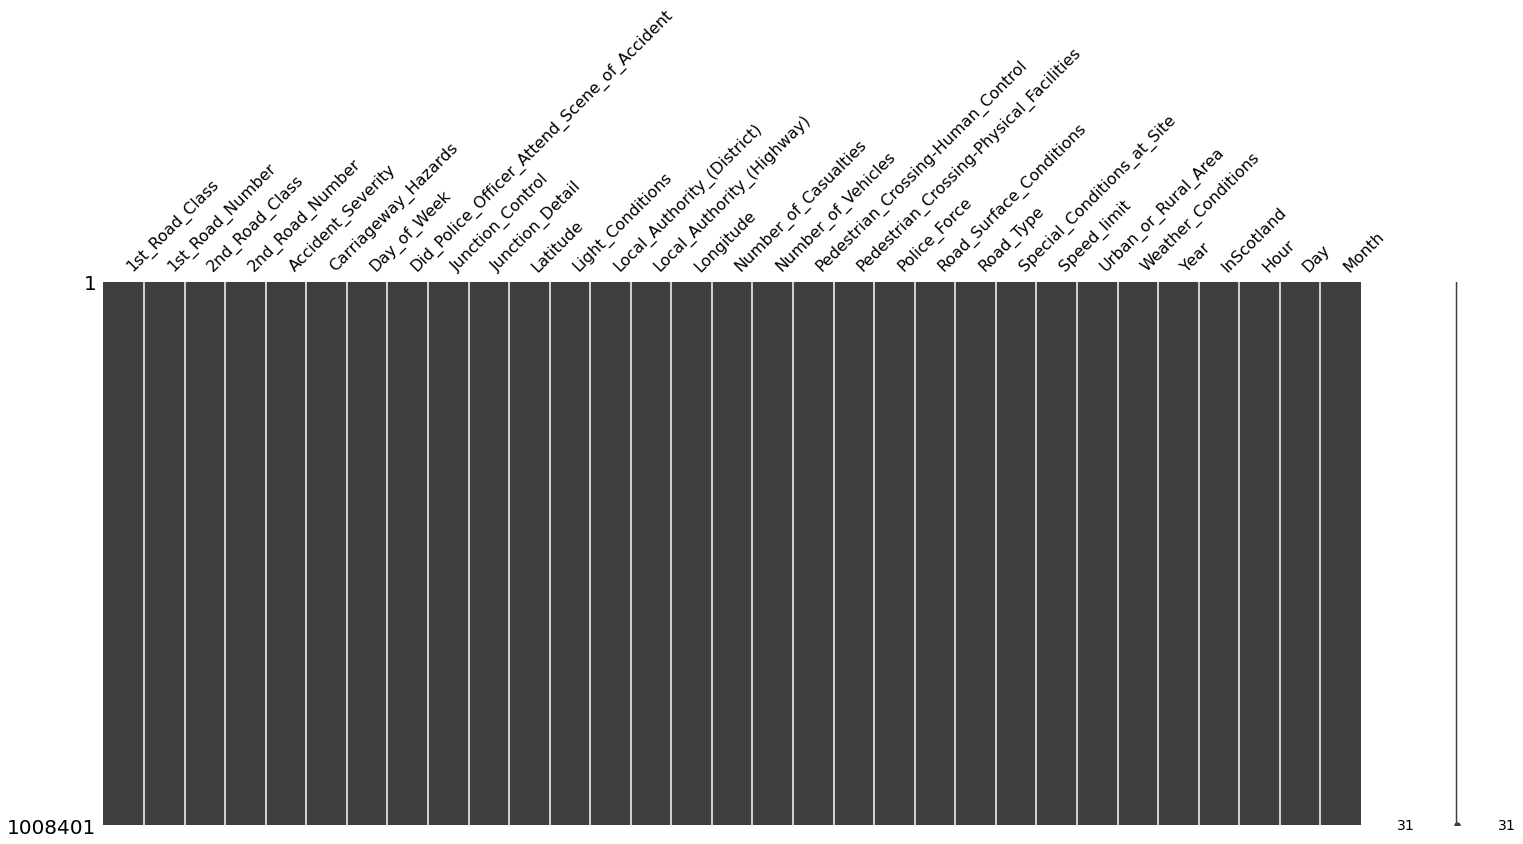

In [24]:
import missingno as msno

msno.matrix(df3)

In [25]:
#label encoder on cat_cols
label_encoder=LabelEncoder()
for cat_cols in cat_cols:
    df3[cat_cols]= label_encoder.fit_transform(df3[cat_cols])

df3.sample(10)

,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Accident_Severity,Carriageway_Hazards,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,Junction_Control,Junction_Detail,Latitude,Light_Conditions,Local_Authority_(District),Local_Authority_(Highway),Longitude,Number_of_Casualties,Number_of_Vehicles,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Speed_limit,Urban_or_Rural_Area,Weather_Conditions,Year,InScotland,Hour,Day,Month
975451,4,0.0,4,0.0,1,1,2,1.0,2,4,51.237620,4,164,77,-0.925628,1,1,0.0,0.0,20,0,3,5,60,0,1,2010,0,20,31,7
802920,0,12.0,3,631.0,0,1,1,1.0,3,7,52.592448,1,151,122,1.720166,1,2,0.0,0.0,30,0,2,5,50,2,1,2009,0,18,26,1
518546,4,0.0,4,0.0,0,1,5,1.0,3,9,51.432100,4,245,128,-2.871280,1,2,0.0,0.0,0,4,3,5,30,2,1,2007,0,15,20,2
548633,3,0.0,4,0.0,0,1,6,1.0,1,0,51.525652,4,55,30,-0.125425,1,1,0.0,5.0,29,4,3,5,30,2,5,2008,0,10,30,4
40978,4,0.0,2,6206.0,0,1,6,2.0,3,9,53.584998,4,32,16,-2.429724,1,2,0.0,0.0,18,0,3,5,30,2,1,2005,0,14,13,7
321424,2,3032.0,4,0.0,0,1,0,1.0,2,4,51.288484,3,153,180,-0.637337,1,1,0.0,0.0,42,0,3,5,60,0,1,2006,0,23,13,1
255359,4,0.0,4,0.0,0,1,3,1.0,3,9,53.365116,1,303,158,-1.541317,1,2,0.0,0.0,38,0,3,5,30,2,1,2006,0,20,29,1
259568,4,0.0,4,0.0,0,1,4,1.0,3,9,54.687654,4,165,80,-1.219225,1,2,0.0,0.0,6,0,3,5,30,2,1,2006,0,19,20,7
697175,4,0.0,4,0.0,0,1,2,1.0,3,0,51.473404,4,59,31,-3.237792,1,2,0.0,0.0,37,0,3,5,30,2,1,2008,0,12,18,10
627434,0,6.0,4,0.0,0,1,4,1.0,2,4,53.094721,4,103,49,-1.517766,2,2,0.0,0.0,8,0,3,5,50,0,1,2008,0,7,17,4


In [26]:
#create a copy of df3
df4=df3.copy()

In [27]:
#identify dependent and independent variables
X=df4.drop('Accident_Severity', axis=1)
y=df4.Accident_Severity

In [28]:
#split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [29]:
def Feature_Scaling(X_train, X_test):
    scaler = StandardScaler()
    X_train_after_Scaling=scaler.fit_transform(X_train)
    X_test_after_Scaling=scaler.fit_transform(X_test)
    return X_train_after_Scaling, X_test_after_Scaling

In [30]:
X_train_after_Scaling,X_test_after_Scaling=Feature_Scaling(X_train,X_test)

Text(0.5, 1.0, 'X_train_after_Scaling')

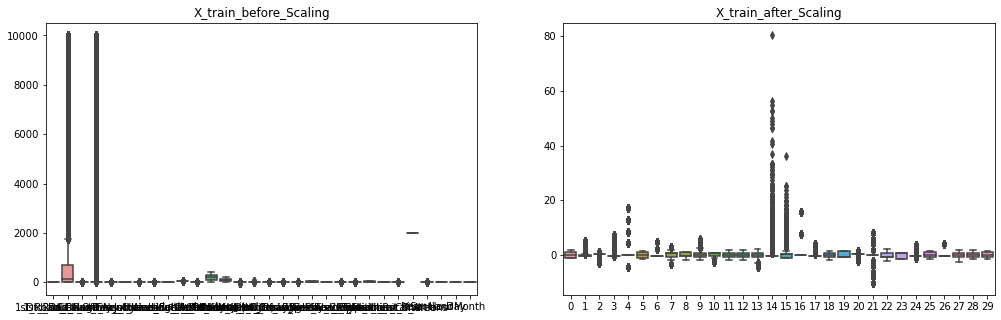

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplots(figsize=(17,5))
plt.subplot(1,2,1)
sns.boxplot(data=X_train)
plt.title('X_train_before_Scaling')
plt.subplot(1,2,2)
sns.boxplot(data=X_train_after_Scaling)
plt.title('X_train_after_Scaling')

In [32]:
#X_train_after_Scaling=pd.DataFrame(X_train_after_Scaling)
#X_train_after_Scaling

In [33]:
#counts('Junction_Control')

In [34]:
#def counts(col):
 #   return df2[col].value_counts()

In [35]:
#next Scaling, PCA
df3['Accident_Severity'].value_counts()

0    860259
1    134018
2     14124
Name: Accident_Severity, dtype: int64

In [36]:
corr_matrix=df3.corr()
corr_matrix['Accident_Severity'].sort_values(ascending=False)

Accident_Severity                              1.000000
Number_of_Casualties                           0.098224
Speed_limit                                    0.080676
2nd_Road_Class                                 0.049441
InScotland                                     0.031603
Latitude                                       0.029814
Road_Type                                      0.015817
Carriageway_Hazards                            0.003918
1st_Road_Number                                0.001457
Day                                            0.001387
Month                                          0.001097
Local_Authority_(District)                     0.001055
Hour                                          -0.000555
Year                                          -0.002706
Local_Authority_(Highway)                     -0.003021
Longitude                                     -0.003535
Pedestrian_Crossing-Physical_Facilities       -0.004308
Police_Force                                  -0

# Model Implementation: Random Forest

In [37]:
#models implementation and evaluation

from sklearn.ensemble import RandomForestClassifier
# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 100) 
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train_after_Scaling, y_train)
 
# performing predictions on the test dataset
y_pred = clf.predict(X_test_after_Scaling)
 
# metrics are used to find accuracy or error
from sklearn import metrics 
print()
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))


ACCURACY OF THE MODEL:  0.8532484468046073


## Feature Importance

In [38]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train_after_Scaling,y_train)

RandomForestClassifier()

In [39]:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(n_jobs=1)

In [40]:
feature_imp = pd.Series(clf.feature_importances_).sort_values(ascending=False)
feature_imp

9     0.108406
13    0.107863
28    0.084971
1     0.070043
27    0.069111
11    0.064396
29    0.062947
12    0.052521
5     0.051004
25    0.048137
18    0.038126
15    0.025509
14    0.022100
8     0.021860
0     0.021472
3     0.019034
22    0.017226
7     0.016461
17    0.013008
24    0.012939
19    0.011463
10    0.011175
6     0.011064
20    0.010673
2     0.008004
23    0.006990
21    0.005562
4     0.004635
26    0.002096
16    0.001205
dtype: float64

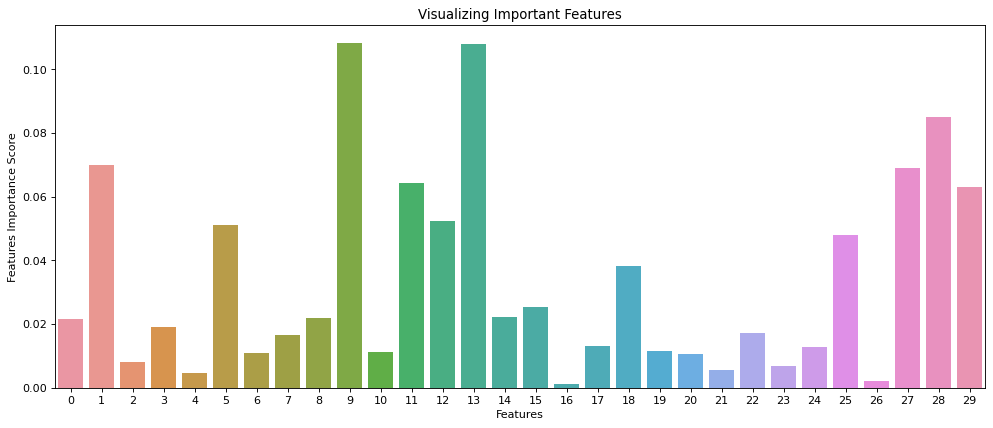

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pyplot import figure
figure(figsize=(15, 6), dpi=80)

# Creating a bar plot
sns.barplot(x=feature_imp.index, y=feature_imp)
# Add labels to your graph
plt.xlabel('Features')
plt.ylabel('Features Importance Score')
plt.title("Visualizing Important Features")
#plt.legend()
plt.show()


## ROC Curve

In [43]:
 yhat = clf.predict_proba(X_test_after_Scaling)

 def plot_roc_curve(y_test, y_pred):
     n_classes = len(np.unique(y_test))
     y_test = label_binarize(y_test, classes=np.arange(n_classes))

     # Compute ROC curve and ROC area for each class
     fpr = dict()
     tpr = dict()
     roc_auc = dict()
     thresholds = dict()
     for i in range(n_classes):
       fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i], y_pred[:, i], drop_intermediate=False)
     roc_auc[i] = auc(fpr[i], tpr[i])

     # Compute micro-average ROC curve and ROC area
     fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
     roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

     # First aggregate all false positive rates
     all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

     # Then interpolate all ROC curves at this points
     mean_tpr = np.zeros_like(all_fpr)
     for i in range(n_classes):
       mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

     # Finally average it and compute AUC
     mean_tpr /= n_classes

     fpr["macro"] = all_fpr
     tpr["macro"] = mean_tpr
     roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

     # Plot all ROC curves
     #plt.figure(figsize=(10,5))
     plt.figure(dpi=600)
     lw = 2
     plt.plot(fpr["micro"], tpr["micro"],
     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
     color="deeppink", linestyle=":", linewidth=4,)

     plt.plot(fpr["macro"], tpr["macro"],
     label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
     color="navy", linestyle=":", linewidth=4,)

     colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "blue"])
     for i, color in zip(range(n_classes), colors):
       plt.plot(fpr[i], tpr[i], color=color, lw=lw,
       label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),)

     plt.plot([0, 1], [0, 1], "k--", lw=lw)
     plt.xlim([0.0, 1.0])
     plt.ylim([0.0, 1.05])
     plt.xlabel("False Positive Rate")
     plt.ylabel("True Positive Rate")
     plt.title("Receiver Operating Characteristic (ROC) curve")
     plt.legend()

NameError: name 'cycle' is not defined

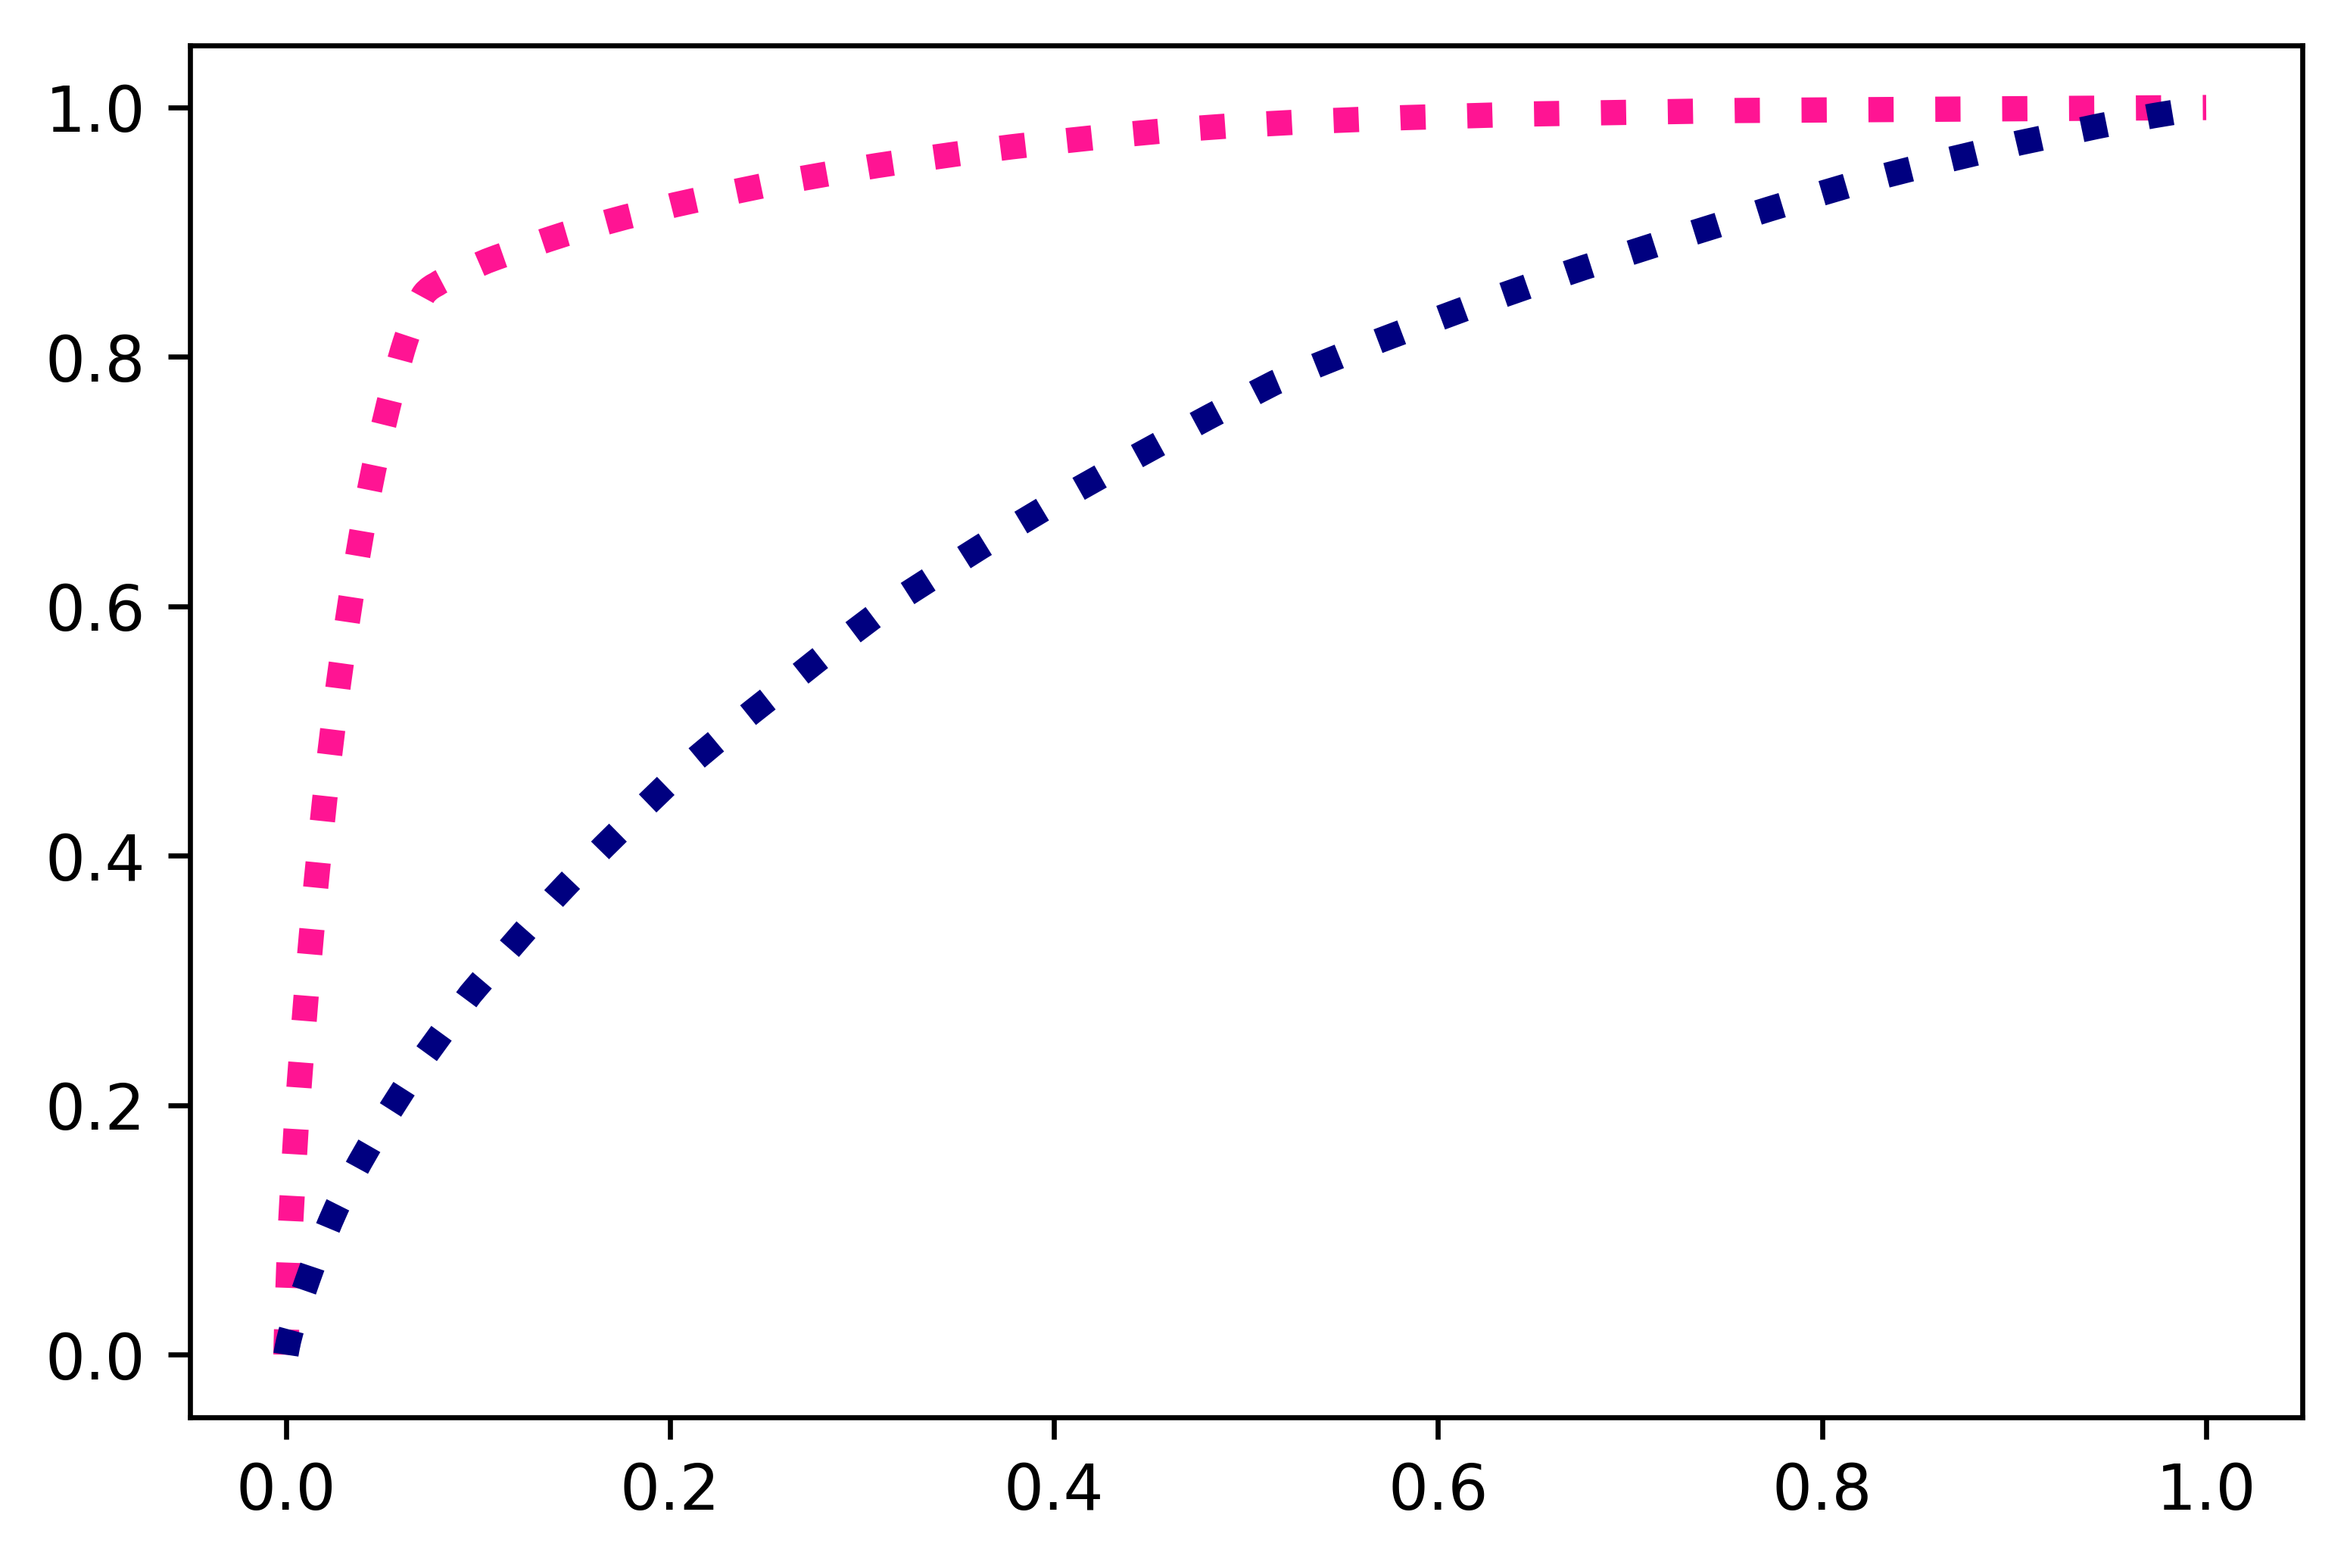

In [44]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

plot_roc_curve(y_test, yhat)